<a href="https://colab.research.google.com/github/aberah29/Breast-Cancer-Classification-Using-Python-/blob/main/Breast_Cancer_Classification_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing The Libraries

In [ ]:
# Importing essential libraries
import os  # Provides functions to interact with the operating system
import numpy as np  # For numerical operations
import pandas as pd  # For handling and manipulating data

# Importing TensorFlow for building and training deep learning models
import tensorflow as tf

# Importing metrics from scikit-learn for model evaluation
from sklearn.metrics import *

# Importing libraries for visualization
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns  # For advanced visualizations built on top of Matplotlib

# Importing tools from TensorFlow Keras for data preprocessing and model creation
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For image augmentation
from tensorflow.keras import layers, models, regularizers, callbacks  # Essential Keras modules for creating models
from tensorflow.keras.applications import VGG19, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# Setting up an automatic tuning parameter for TensorFlow's data pipeline
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Reading the CSV file containing folds information into a Pandas DataFrame
folds_dataframe = pd.read_csv('/content/drive/MyDrive/Datasets/Images/Folds.csv')

# Path to the directory containing the BreaKHis dataset
images_directory = '/content/drive/MyDrive/Datasets/Images/BreaKHis_v1/'

# Defining the tumor types present in the dataset
tumor_types = ['benign', 'malignant']


# Let's Check for the Duplicate Values in the CSV File

In [ ]:
# Check for duplicate filenames
duplicate_filename_count = folds_dataframe['filename'].duplicated().sum()
print(f'Number of duplicate filenames: {duplicate_filename_count}')

Number of duplicate filenames: 31636


# Removing the Duplicate Values

In [ ]:
# Remove duplicate rows based on the 'filename' column to retain only unique entries
folds_dataframe = folds_dataframe.drop_duplicates(subset='filename', keep='first')
# Print the updated shape of the DataFrame
print(f'Updated shape of the DataFrame: {folds_dataframe.shape}')

Updated shape of the DataFrame: (7909, 4)


# Making Paths For Each Image File and Declaring the Labels for Each Image

In [ ]:
# Rename the 'filename' column to 'path'
folds_dataframe = folds_dataframe.rename(columns={'filename': 'path'})

# Extract and assign labels from the path
folds_dataframe['label'] = folds_dataframe['path'].apply(lambda x: x.split('/')[3])

# Convert labels to integer indices
folds_dataframe['label_int'] = folds_dataframe['label'].apply(lambda x: tumor_types.index(x))

# Extract and assign file names from the path
folds_dataframe['file_name'] = folds_dataframe['path'].apply(lambda x: x.split('/')[-1])

# Update the 'path' column to include the full image folder path
folds_dataframe['path'] = folds_dataframe['path'].apply(lambda x: images_directory + x)

# Display the first three rows of the DataFrame
folds_dataframe.head(3)


,fold,mag,grp,path,label,label_int,file_name
0,1,100,train,/content/drive/MyDrive/Datasets/Images/BreaKHi...,benign,0,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,/content/drive/MyDrive/Datasets/Images/BreaKHi...,benign,0,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,/content/drive/MyDrive/Datasets/Images/BreaKHi...,benign,0,SOB_B_A-14-22549AB-100-003.png


# Data Visualization

Count of Benign    :  2480
Count of Malignant :  5429


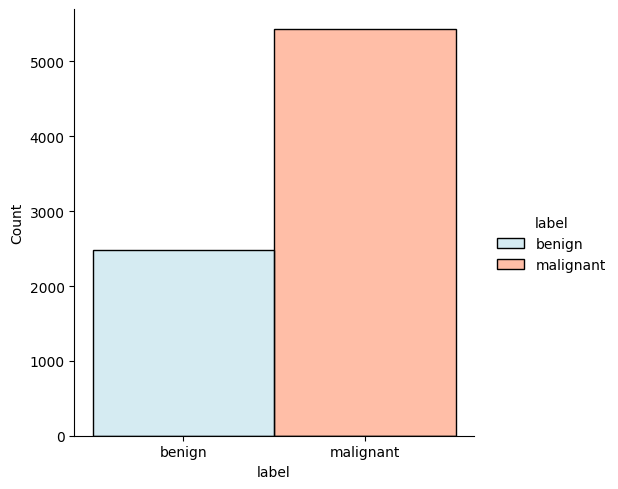

In [ ]:
# Defining colors for tumor types
ax = sns.displot(
    data=folds_dataframe,
    x='label',
    hue='label',
    palette={'benign': 'lightblue', 'malignant': 'coral'}
)

# Displaying the count of each label
print('Count of Benign    : ', folds_dataframe[folds_dataframe['label'] == 'benign']['label'].count())
print('Count of Malignant : ', folds_dataframe[folds_dataframe['label'] == 'malignant']['label'].count())


# Spliting Dataset into Training and Testing

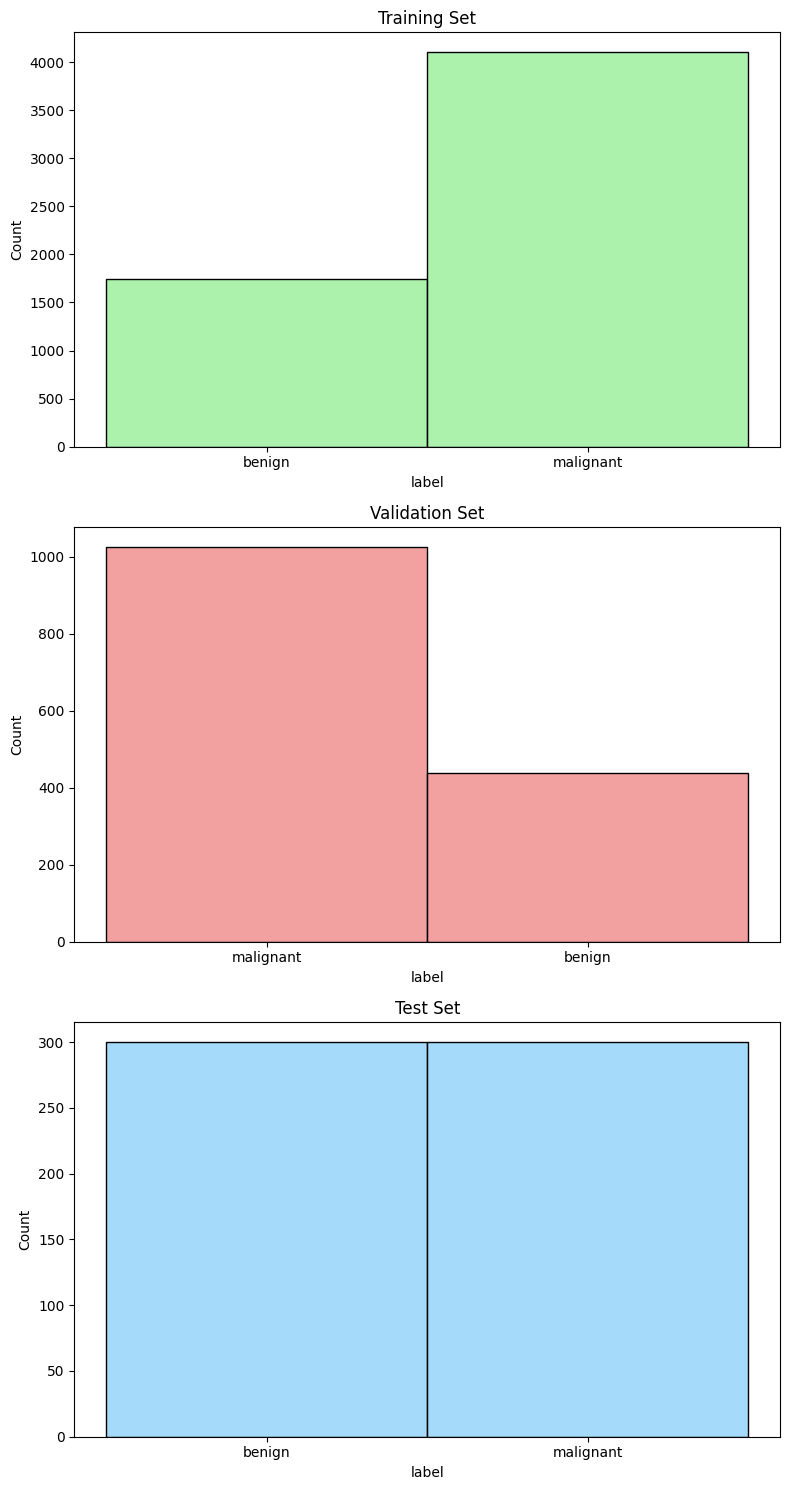

Training set
label
malignant    4104
benign       1743
Name: count, dtype: int64

Validation set
label
malignant    1025
benign        437
Name: count, dtype: int64

Test set
label
benign       300
malignant    300
Name: count, dtype: int64


In [ ]:
# Remove 600 samples from the dataset for testing
test_dataset = folds_dataframe.groupby('label').sample(n=300)
train_dataset = folds_dataframe.drop(test_dataset.index).reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

# Split training and validation sets
validation_dataset = train_dataset.sample(frac=0.2)
train_dataset = train_dataset.drop(validation_dataset.index).reset_index(drop=True)
validation_dataset = validation_dataset.reset_index(drop=True)

# Assign set labels and combine data
test_dataset['set'] = 'test'
train_dataset['set'] = 'train'
validation_dataset['set'] = 'valid'
combined_dataset = pd.concat([train_dataset, validation_dataset, test_dataset])

# Set up the figure with a column of three subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 15))

# Plot each distribution in a different color and assign to specific axes
sns.histplot(data=train_dataset, x='label', color='lightgreen', ax=axes[0])
axes[0].set_title('Training Set')

sns.histplot(data=validation_dataset, x='label', color='lightcoral', ax=axes[1])
axes[1].set_title('Validation Set')

sns.histplot(data=test_dataset, x='label', color='lightskyblue', ax=axes[2])
axes[2].set_title('Test Set')

# Show the plots in a vertical layout
plt.tight_layout()
plt.show()

# Print counts for each set
print('Training set')
print(train_dataset['label'].value_counts())

print('\nValidation set')
print(validation_dataset['label'].value_counts())

print('\nTest set')
print(test_dataset['label'].value_counts())


# UpSampling Dataset to Remove Class Imbalance

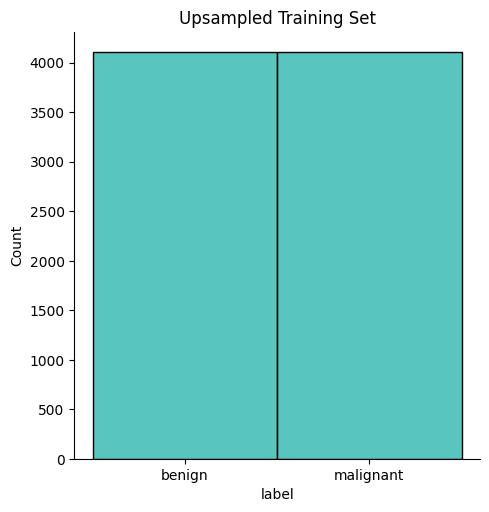

label
benign       4104
malignant    4104
Name: count, dtype: int64


In [ ]:
# Upsample the training dataset
max_count = np.max(train_dataset['label'].value_counts())
train_dataset = train_dataset.groupby('label').sample(n=max_count, replace=True).reset_index(drop=True)

# Plot distribution after upsampling
ax = sns.displot(data=train_dataset, x='label', color='lightseagreen')
ax.set(title='Upsampled Training Set')
plt.show()

# Display counts to verify upsampling
print(train_dataset['label'].value_counts())


# Applying Data Augmentation

In [ ]:
# Convert 'label_int' to string type for categorical class mode
train_dataset['label_int'] = train_dataset['label_int'].astype(str)
validation_dataset['label_int'] = validation_dataset['label_int'].astype(str)

# Data augmentation setup with updated values
train_image_generator = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use a simpler validation generator with rescaling only
validation_image_generator = ImageDataGenerator(rescale=1./255)

# Training data generator setup
train_data_generator = train_image_generator.flow_from_dataframe(
    dataframe=train_dataset,
    directory='',
    x_col='path',
    y_col='label_int',
    target_size=(150, 150),
    batch_size=64,
    class_mode='sparse'
)

# Validation data generator setup
validation_data_generator = validation_image_generator.flow_from_dataframe(
    dataframe=validation_dataset,
    directory='',
    x_col='path',
    y_col='label_int',
    target_size=(150, 150),
    batch_size=64,
    class_mode='sparse'
)


Found 8208 validated image filenames belonging to 2 classes.
Found 1462 validated image filenames belonging to 2 classes.


# Defining the Model

In [ ]:
# Define the model
model = models.Sequential()

# First convolutional block
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(150, 150, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Second convolutional block
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Third convolutional block
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.35))

# Fourth convolutional block
model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Fifth convolutional block
model.add(layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Flatten and fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation='softmax'))  # Adjust output layer for 2 classes


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 146, 146, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 146, 146, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 71, 71, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 69, 69, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 69, 69, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 34, 34, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 34, 34, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,769,442 (10.56 MB)

 Trainable params: 2,765,986 (10.55 MB)

 Non-trainable params: 3,456 (13.50 KB)

# Model Training

In [ ]:
# Define callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
# Train the model with callbacks
history = model.fit(
    train_data_generator,        # Training data generator
    epochs=50,                   # Increased epochs to allow better convergence
    validation_data=validation_data_generator,  # Validation data generator
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

model.save('/content/drive/MyDrive/Custom_model.h5')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 2219s 16s/step - accuracy: 0.7344 - loss: 2.2998 - val_accuracy: 0.6997 - val_loss: 2.5441 - learning_rate: 0.0010
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.8070 - loss: 1.9525 - val_accuracy: 0.6997 - val_loss: 2.0838 - learning_rate: 0.0010
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8457 - loss: 1.6459 - val_accuracy: 0.6997 - val_loss: 2.9764 - learning_rate: 0.0010
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8552 - loss: 1.4167 - val_accuracy: 0.7326 - val_loss: 1.8837 - learning_rate: 0.0010
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8635 - loss: 1.1987 - val_accuracy: 0.8440 - val_loss: 1.3486 - learning_rate: 0.0010
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.8691 - loss: 1.0131 - val_accuracy: 0.7818 - val_loss: 1.1483 - learning_rate: 0.0010
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8795 - loss: 0.8502 - va

# Training Curves For Custom CNN

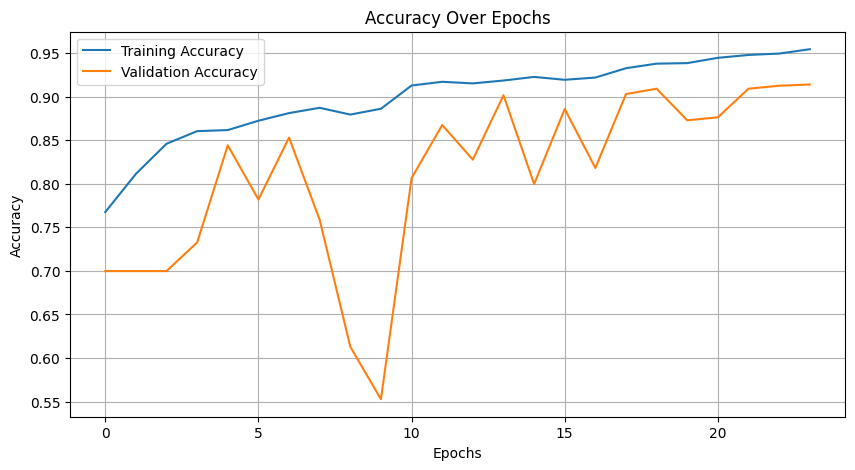

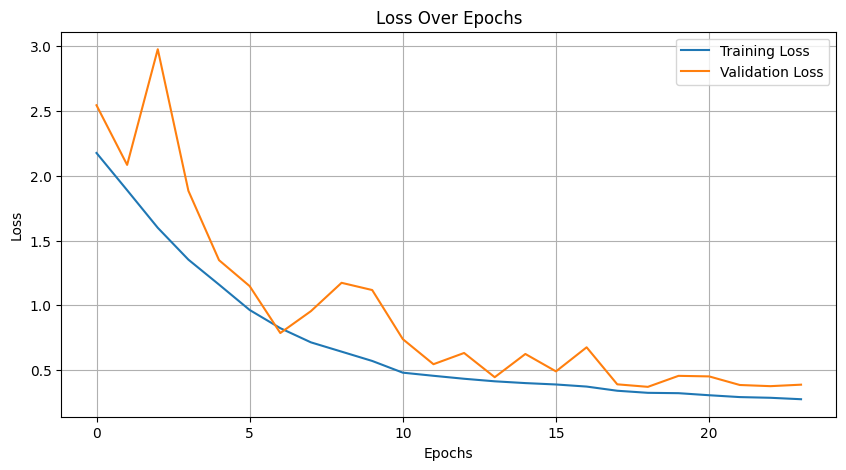

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Evaluating the Test set Custom CNN

In [ ]:
# Convert the 'label_int' column to string type for compatibility
# with the data generator's expected label format.
test_dataset['label_int'] = test_dataset['label_int'].astype(str)

# Prepare the test set with rescaled pixel values to the range [0, 1].
test_datagen = ImageDataGenerator(rescale=1./255)

# Initialize the test data generator
# This generator reads images and labels directly from the DataFrame.
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_dataset,  # DataFrame containing the test data
    directory='',        # Leave empty if file paths in the DataFrame are absolute
    x_col='path',        # Column in the DataFrame containing image file paths
    y_col='label_int',   # Column containing the labels as strings
    target_size=(150, 150),  # Resize images to the specified input dimensions
    batch_size=32,       # Number of samples per batch
    class_mode='sparse', # Sparse mode expects integer labels (converted to strings earlier)
    shuffle=False        # Maintain the original order of samples for evaluation
)

# Evaluate the trained model using the test data generator
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Make predictions on the test set
predictions = model.predict(test_generator)
# Extract predicted class indices from probability distributions
predicted_classes = np.argmax(predictions, axis=1)
# Retrieve the true class labels from the generator
true_classes = test_generator.classes
# Get the mapping of class indices to class names
class_labels = list(test_generator.class_indices.keys())


Found 600 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 214s 12s/step - accuracy: 0.9253 - loss: 0.3688
Test Accuracy: 0.93
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 479ms/step


# Evaluation Custom CNN On Test Set


Classification Report:
               precision    recall  f1-score   support

      Benign       0.93      0.92      0.92       300
   Malignant       0.92      0.93      0.93       300

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.92       600
weighted avg       0.93      0.93      0.92       600



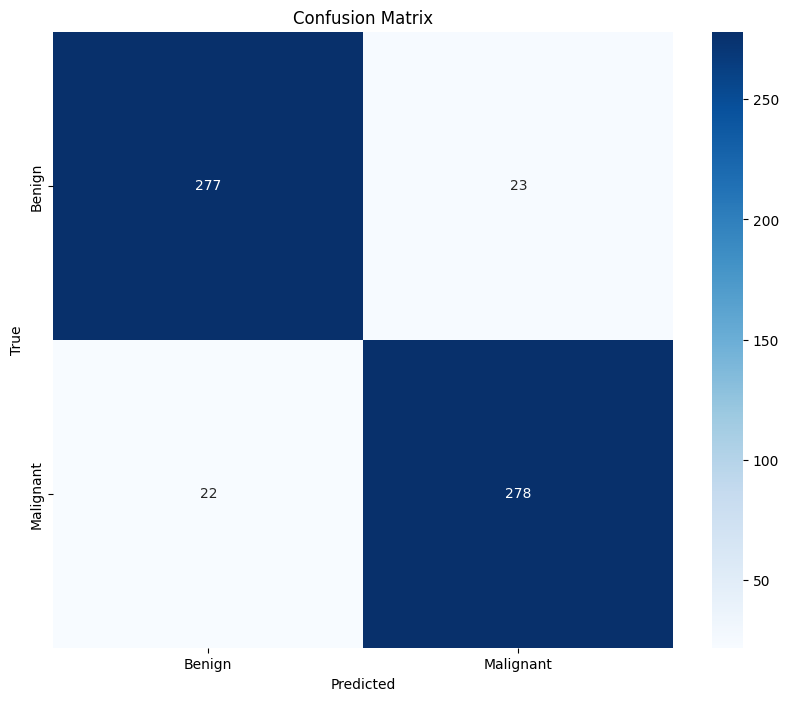

In [ ]:
def evaluate_classification(true_classes, predicted_classes, class_labels):
    """
    Generate and display a classification report and confusion matrix.

    Args:
        true_classes (array-like): True class labels.
        predicted_classes (array-like): Predicted class labels.
        class_labels (list): List of class label names.

    Returns:
        None
    """
    # Classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print("\nClassification Report:\n", report)

    # Confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

class_labels = ["Benign", "Malignant"]
evaluate_classification(true_classes, predicted_classes, class_labels)

# Importing the Pretrained Model VGG19

In [ ]:
# Define constants
INPUT_SHAPE = (150, 150, 3)  # Image input shape
NUM_CLASSES = 2  # Number of classes (e.g., Benign, Malignant)
LEARNING_RATE = 0.001
EPOCHS = 50

# Function to build VGG19 model
def build_vgg19_model():
    base_model = VGG19(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)
    for layer in base_model.layers[:-2]:
        layer.trainable = False

    x = layers.Flatten()(base_model.output)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.35)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.35)(x)
    output = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


# Training VGG19 Model

In [ ]:
# Train VGG19 model
vgg19_model = build_vgg19_model()
print("Training VGG19 model...")
vgg19_history = vgg19_model.fit(
    train_data_generator,
    epochs=EPOCHS,
    validation_data=validation_data_generator,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
    ]
)

# Save VGG19 model
vgg19_model.save('/content/drive/MyDrive/VGG19_model.h5')

Training VGG19 model...
Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.6222 - loss: 0.8501 - val_accuracy: 0.8037 - val_loss: 0.4369 - learning_rate: 0.0010
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.7929 - loss: 0.4607 - val_accuracy: 0.8051 - val_loss: 0.4336 - learning_rate: 0.0010
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8073 - loss: 0.4324 - val_accuracy: 0.8228 - val_loss: 0.4269 - learning_rate: 0.0010
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.8216 - loss: 0.3995 - val_accuracy: 0.8372 - val_loss: 0.3755 - learning_rate: 0.0010
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.8472 - loss: 0.3675 - val_accuracy: 0.8516 - val_loss: 0.3595 - learning_rate: 0.0010
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.8556 - loss: 0.3532 - val_accuracy: 0.8659 - val_loss: 0.3411 - learning_rate: 0.0010
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - acc

# Training Curves for VGG19

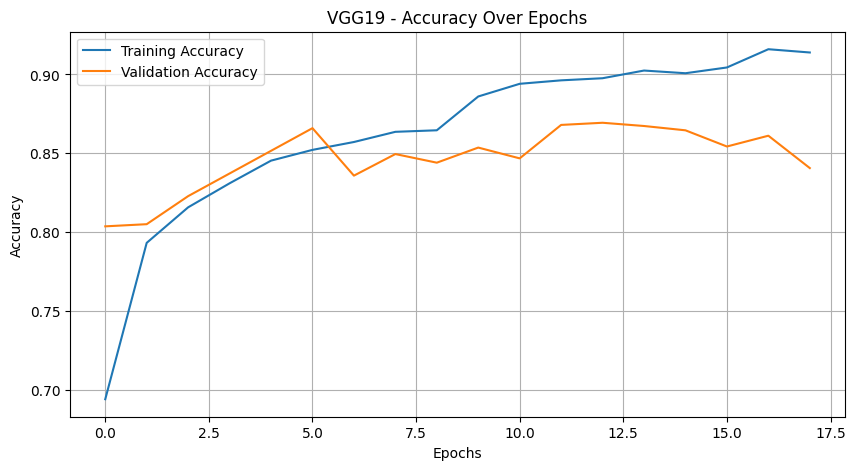

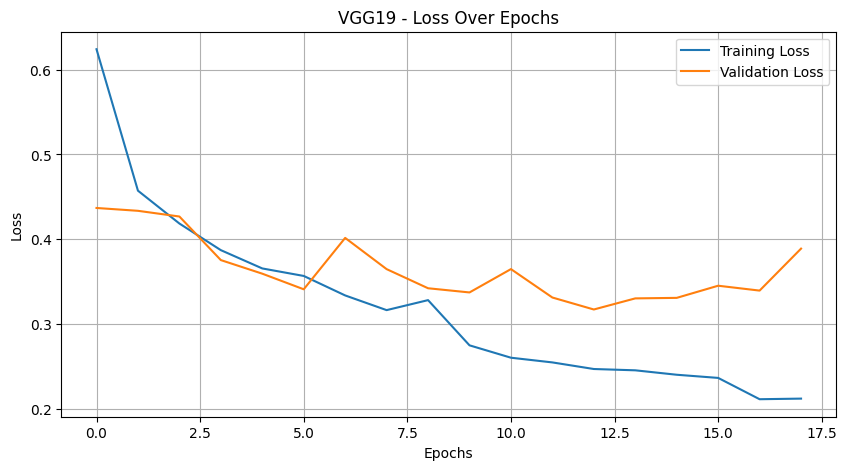

In [ ]:
# Plot training history for VGG19
def plot_vgg19_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('VGG19 - Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('VGG19 - Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_vgg19_history(vgg19_history)

# Evaluating the VGG19 Model on Test Set

In [ ]:
# Evaluate the trained model using the test data generator
test_loss, test_accuracy = vgg19_model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Make predictions on the test set
predictions = vgg19_model.predict(test_generator)
# Extract predicted class indices from probability distributions
predicted_classes = np.argmax(predictions, axis=1)
# Retrieve the true class labels from the generator
true_classes = test_generator.classes
# Get the mapping of class indices to class names
class_labels = list(test_generator.class_indices.keys())

19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 937ms/step - accuracy: 0.8405 - loss: 0.4086
Test Accuracy: 0.86
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 499ms/step


# Classification Report and Confusion Matrix for VGG19


Classification Report:
               precision    recall  f1-score   support

      Benign       0.89      0.81      0.85       300
   Malignant       0.82      0.90      0.86       300

    accuracy                           0.85       600
   macro avg       0.86      0.85      0.85       600
weighted avg       0.86      0.85      0.85       600



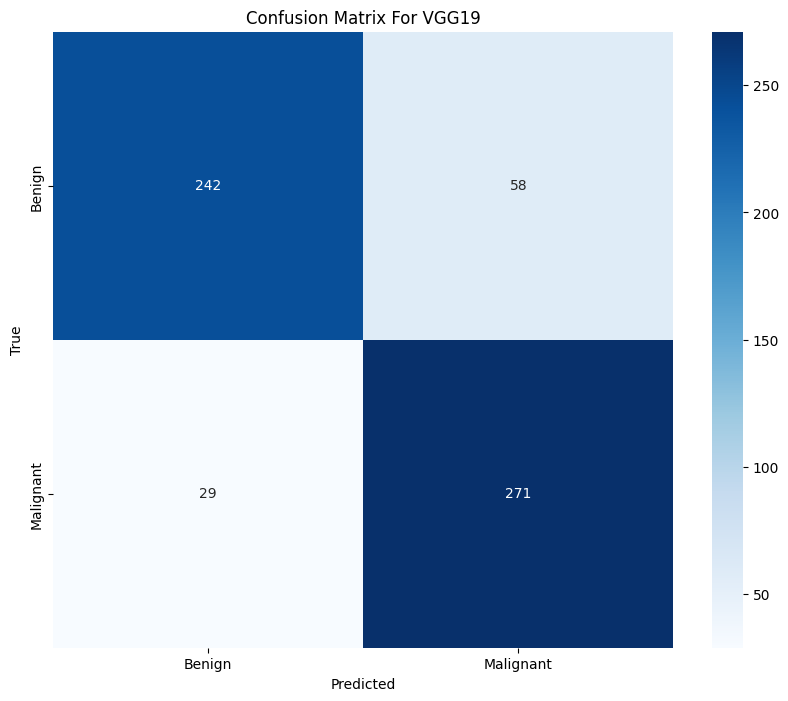

In [ ]:
def evaluate_classification(true_classes, predicted_classes, class_labels):
    """
    Generate and display a classification report and confusion matrix.

    Args:
        true_classes (array-like): True class labels.
        predicted_classes (array-like): Predicted class labels.
        class_labels (list): List of class label names.

    Returns:
        None
    """
    # Classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print("\nClassification Report:\n", report)

    # Confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix For VGG19")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

class_labels = ["Benign", "Malignant"]
evaluate_classification(true_classes, predicted_classes, class_labels)

# Importing Inception Model

In [ ]:
# Define constants
INPUT_SHAPE = (150, 150, 3)  # Image input shape
NUM_CLASSES = 2  # Number of classes (e.g., Benign, Malignant)
LEARNING_RATE = 0.001
EPOCHS = 50
# Function to build InceptionV3 model
def build_inceptionv3_model():
    base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)
    for layer in base_model.layers:
        layer.trainable = False

    x = layers.Flatten()(base_model.output)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model



# Training the Inceptionv3 Model

In [ ]:
# Train InceptionV3 model
inceptionv3_model = build_inceptionv3_model()
print("Training InceptionV3 model...")
inceptionv3_history = inceptionv3_model.fit(
    train_data_generator,
    epochs=EPOCHS,
    validation_data=validation_data_generator,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
    ]
)

# Save InceptionV3 model
inceptionv3_model.save('/content/drive/MyDrive/InceptionV3_model.h5')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training InceptionV3 model...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 2222s 16s/step - accuracy: 0.5739 - loss: 3.1299 - val_accuracy: 0.7743 - val_loss: 0.5476 - learning_rate: 0.0010
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.7038 - loss: 0.5915 - val_accuracy: 0.7927 - val_loss: 0.4975 - learning_rate: 0.0010
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.7086 - loss: 0.5634 - val_accuracy: 0.8112 - val_loss: 0.4568 - learning_rate: 0.0010
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.7245 - loss: 0.5464 - val_accuracy: 0.7859 - val_loss: 0.4910 - learning_rate: 0.0010
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.7204 - loss: 0.5643 - val_accuracy: 0.8126 - val_loss: 0.4489 - learning_rate: 0.0010
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.7211 - loss: 0.5422 - val_accuracy: 0.7503 - val_loss: 0.5121 - learning_rate: 0.0010
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.7290 - loss: 0.5249 - va

# Ploting the Training Curves for Inception V3

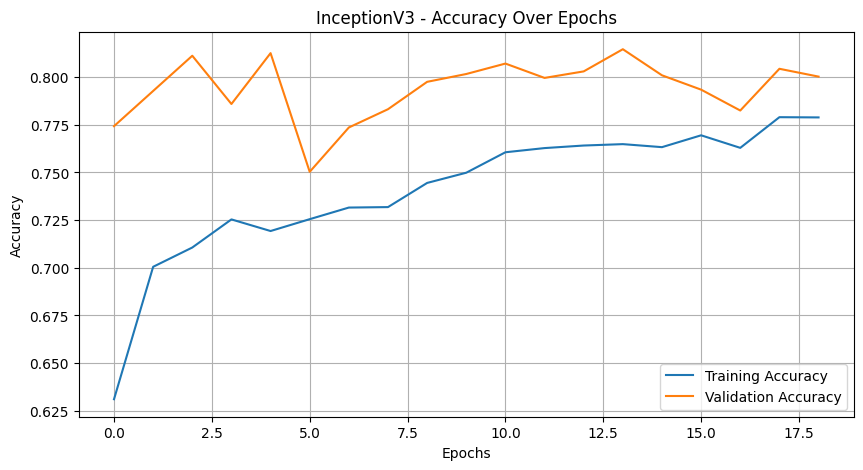

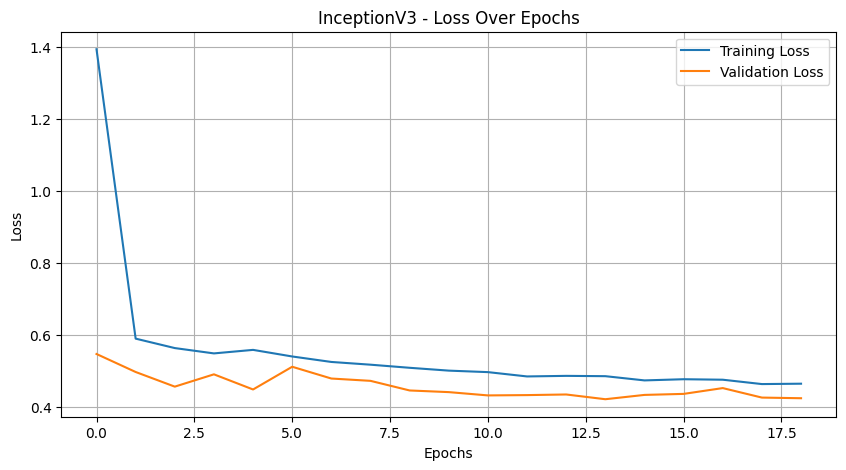

In [ ]:
# Plot training history for InceptionV3
def plot_inceptionv3_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('InceptionV3 - Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('InceptionV3 - Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_inceptionv3_history(inceptionv3_history)

# Evaluating the InceptionV3 Model

In [ ]:
# Convert the 'label_int' column to string type for compatibility
# with the data generator's expected label format.
test_dataset['label_int'] = test_dataset['label_int'].astype(str)

# Prepare the test set with rescaled pixel values to the range [0, 1].
test_datagen = ImageDataGenerator(rescale=1./255)

# Initialize the test data generator
# This generator reads images and labels directly from the DataFrame.
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_dataset,  # DataFrame containing the test data
    directory='',        # Leave empty if file paths in the DataFrame are absolute
    x_col='path',        # Column in the DataFrame containing image file paths
    y_col='label_int',   # Column containing the labels as strings
    target_size=(150, 150),  # Resize images to the specified input dimensions
    batch_size=32,       # Number of samples per batch
    class_mode='sparse', # Sparse mode expects integer labels (converted to strings earlier)
    shuffle=False        # Maintain the original order of samples for evaluation
)

# Evaluate the trained model using the test data generator
test_loss, test_accuracy = inceptionv3_model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Evaluate the trained model using the test data generator
test_loss, test_accuracy = inceptionv3_model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Make predictions on the test set
predictions = inceptionv3_model.predict(test_generator)
# Extract predicted class indices from probability distributions
predicted_classes = np.argmax(predictions, axis=1)
# Retrieve the true class labels from the generator
true_classes = test_generator.classes
# Get the mapping of class indices to class names
class_labels = list(test_generator.class_indices.keys())

Found 600 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 796ms/step - accuracy: 0.7878 - loss: 0.5172
Test Accuracy: 0.79
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 532ms/step - accuracy: 0.7878 - loss: 0.5172
Test Accuracy: 0.79
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 744ms/step


# Classification Report and Confusion Matrix for Inceptionv3


Classification Report:
               precision    recall  f1-score   support

      Benign       0.81      0.77      0.79       300
   Malignant       0.78      0.81      0.80       300

    accuracy                           0.79       600
   macro avg       0.79      0.79      0.79       600
weighted avg       0.79      0.79      0.79       600



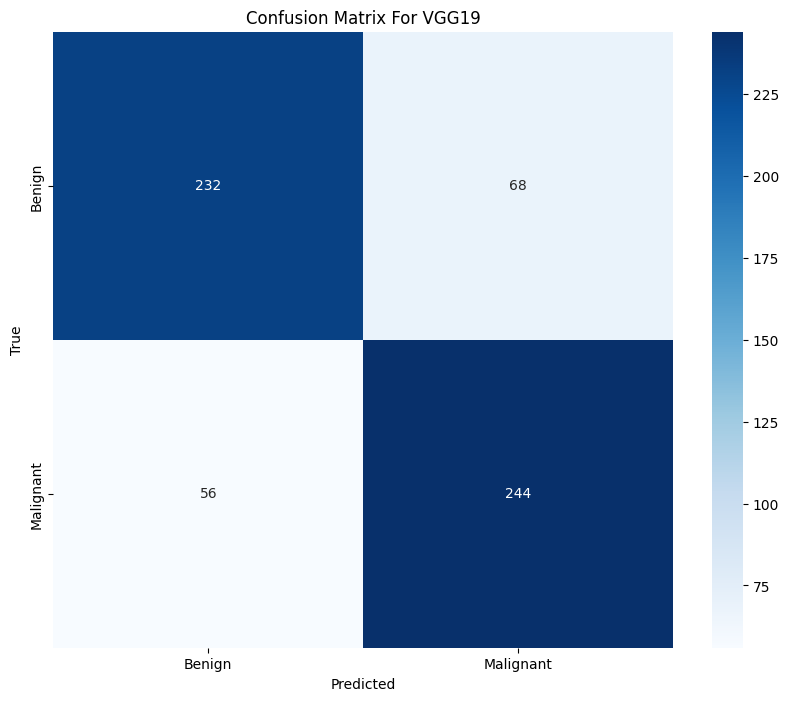

In [ ]:
def evaluate_classification(true_classes, predicted_classes, class_labels):
    """
    Generate and display a classification report and confusion matrix.

    Args:
        true_classes (array-like): True class labels.
        predicted_classes (array-like): Predicted class labels.
        class_labels (list): List of class label names.

    Returns:
        None
    """
    # Classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print("\nClassification Report:\n", report)

    # Confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix For VGG19")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

class_labels = ["Benign", "Malignant"]
evaluate_classification(true_classes, predicted_classes, class_labels)